# Split utterances using VAD

Let say you have a long audio sample, and you want to cut to small samples based on utterances. Malaya-speech can help you!

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/split-utterances](https://github.com/huseinzol05/malaya-speech/tree/master/example/utterances).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline

### List available VAD model

In [2]:
malaya_speech.vad.available_model()

,Size (MB),Quantized Size (MB),Accuracy
vggvox-v1,70.8,17.70,0.9500
vggvox-v2,31.1,7.92,0.9594
speakernet,20.3,5.18,0.9000


### Load deep model

I will load quantized model, we found out VAD quantized models have the same accuracy as normal models, read more about VAD at https://malaya-speech.readthedocs.io/en/latest/load-vad.html

In [3]:
vad = malaya_speech.vad.deep_model(model = 'vggvox-v2', quantized = True)

### Load long samples

In [4]:
y, sr = malaya_speech.load('speech/podcast/2x5%20Ep%2010.wav')
len(y) / sr

294.504

294 seconds!

In [5]:
import IPython.display as ipd

ipd.Audio(y[:sr * 10], rate = sr)

In [6]:
from pydub import AudioSegment
import numpy as np

sr = 16000
sound = AudioSegment.from_file('speech/video/70_Peratus_Gaji_Rakyat_Malaysia_Dibelanjakan_Untuk_Barang_Keperluan.mp3')
samples = sound.set_frame_rate(sr).set_channels(1).get_array_of_samples()

In [7]:
samples = np.array(samples)
samples = malaya_speech.utils.astype.int_to_float(samples)

In [8]:
len(samples) / sr

110.106125

### Initiate pipeline

Read more how to use Malaya-Speech VAD model at https://malaya-speech.readthedocs.io/en/latest/load-vad.html#How-to-detect-Voice-Activity.

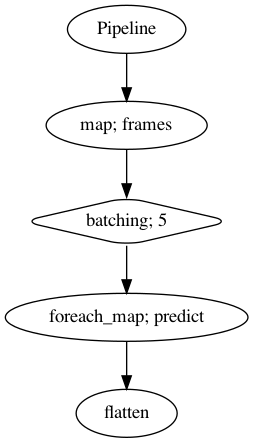

In [9]:
p = Pipeline()

pipeline = (
    p.map(malaya_speech.utils.generator.frames, frame_duration_ms = 30)
    .batching(5)
    .foreach_map(vad.predict)
    .flatten()
)
p.visualize()

In [10]:
%%time

result = p(y)
result.keys()

/Users/huseinzolkepli/Documents/tf-1.15/env/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=480
  n_fft, y.shape[-1]


CPU times: user 5min 34s, sys: 52.3 s, total: 6min 27s
Wall time: 1min 22s


/Users/huseinzolkepli/Documents/tf-1.15/env/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=384
  n_fft, y.shape[-1]


dict_keys(['frames', 'batching', 'predict', 'flatten'])

In [11]:
frames = result['frames']
frames_vad = [
    (frame, result['flatten'][no]) for no, frame in enumerate(frames)
]

### Split utterances based on size negative VAD

So to split based on negative VAD, we need to use `malaya_speech.split.split_vad`,

```python
def split_vad(
    frames,
    n: int = 3,
    negative_threshold: float = 0.1,
    silent_trail: int = 500,
    sample_rate: int = 16000,
    use_negative_as_silent: bool = False,
):
    """
    Split a sample into multiple samples based `n` size of negative VAD.

    Parameters
    ----------
    frames: List[Tuple[Frame, label]]
    n: int, optional (default=3)
        `n` size of negative VAD to assume in one subsample.
    negative_threshold: float, optional (default = 0.1)
        If `negative_threshold` is 0.1, means that, length negative samples must at least 0.1 second.
    silent_trail: int, optional (default = 500)
        If an element is not a voice activity, append with `silent_trail` frame size. 
    sample_rate: int, optional (default = 16000)
        sample rate for frames.
    use_negative_as_silent: bool, optional (default = False)
        If True, will use negative VAD as silent, else, use zeros array size of `silent_trail`.

    Returns
    -------
    result : List[Frame]
    """
```

In [12]:
splitted = malaya_speech.split.split_vad(frames_vad)

In [13]:
ipd.Audio(splitted[0].array, rate = sr)

In [14]:
ipd.Audio(splitted[1].array, rate = sr)

In [15]:
ipd.Audio(splitted[2].array, rate = sr)

In [16]:
ipd.Audio(splitted[3].array, rate = sr)

### Split utterances based on maximum duration VAD

So to split based on maximum duration VAD, we need to use `malaya_speech.split.split_vad_duration`,

```python
def split_vad_duration(
    frames,
    max_duration: float = 5.0,
    negative_threshold: float = 0.1,
    silent_trail = 500,
    sample_rate: int = 16000,
    use_negative_as_silent: bool = False,
):
    """
    Split a sample into multiple samples based maximum duration of voice activities.

    Parameters
    ----------
    frames: List[Tuple[Frame, label]]
    max_duration: float, optional (default = 5.0)
        Maximum duration to assume one sample combined from voice activities.
    negative_threshold: float, optional (default = 0.1)
        If `negative_threshold` is 0.1, means that, length negative samples must at least 0.1 second.
    silent_trail: int, optional (default = 500)
        If an element is not a voice activity, append with `silent_trail` frame size.
    sample_rate: int, optional (default = 16000)
        sample rate for frames.
    use_negative_as_silent: bool, optional (default = False)
        If True, will use negative VAD as silent, else, use zeros array size of `silent_trail`.

    Returns
    -------
    result : List[Frame]
    """
```

In [17]:
splitted = malaya_speech.split.split_vad_duration(frames_vad, negative_threshold = 0.3)

In [18]:
ipd.Audio(splitted[0].array, rate = sr)

In [19]:
ipd.Audio(splitted[1].array, rate = sr)